In [1]:
import sys
from os.path import abspath
sys.path.insert(0, abspath('..'))

from os.path import join

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np


import torch
from torchclust.data import load_data
from torchclust.modules import STC
from torchclust.metrics import SpacePlot, Evaluate
from torchclust.utils.cluster import SphericalKmeans

plot = SpacePlot()
eval = Evaluate()

[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/godwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


>>>>> /home/godwin/Documents/academic/PPD/torchclust/demos
>>>>> data_loader.py cwd:  /home/godwin/Documents/academic/PPD/torchclust/demos


In [2]:
cur = abspath("")
cur

'/home/godwin/Documents/academic/PPD/torchclust/demos'

In [3]:
# Data directory

dataset = 'stackoverflow'
data_in_dir=join(cur, "..", "datasets")
dataset_dir=join(data_in_dir, dataset)
stc_weights=join(data_in_dir, dataset, "artefacts", "STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeNone-norml2-initKmeans.pth")

In [4]:
print(f'data_in_dir: {data_in_dir}')
print(f'dataset_dir: {dataset_dir}')
print(f'stc_weights: {stc_weights}')

data_in_dir: /home/godwin/Documents/academic/PPD/torchclust/demos/../datasets
dataset_dir: /home/godwin/Documents/academic/PPD/torchclust/demos/../datasets/stackoverflow
stc_weights: /home/godwin/Documents/academic/PPD/torchclust/demos/../datasets/stackoverflow/artefacts/STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeNone-norml2-initKmeans.pth


# Load Data with pre-processing 

## StackOverflow

### Config : STC-wdeWord2Vec-scaMinMax-tfeNone-norml2-initKmeans.pth

In [5]:
# STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeNone-norml2-initKmeans.pth

x, y = load_data(dataset=dataset_dir, word_emb='Word2Vec', transform=None, scaler='MinMax', norm='l2')
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(stc_weights)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Embedding started...
Word2Vec words embedding loaded...
Average embedding completed...
### Embedding completed...
Spherical normalization completed...


(torch.Size([18000, 48]),
 torch.Size([2000, 48]),
 torch.Size([18000]),
 torch.Size([2000]))

In [6]:
zt = stc.autoencoder.encoder(X_train)
qt, _ = stc(X_train)
# y_pred = torch.argmax(q_train, dim=1)

In [7]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
kmeans.fit(zt.detach().numpy())
y_km_pred = kmeans.labels_

In [8]:
skmeans = SphericalKmeans(n_clusters=n_clusters, n_init=50)
skmeans.fit(zt.detach().numpy())
y_skm_pred = skmeans.labels_

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

#### Compute metrics

In [9]:
min(y_km_pred), len(np.unique(y_km_pred)), max(y_km_pred)

(0, 20, 19)

In [10]:
min(y_skm_pred), len(np.unique(y_skm_pred)), max(y_skm_pred)

(0, 20, 19)

In [12]:
eval.allMetrics(y_train.detach().numpy(), y_km_pred)

[0.4874, 0.4554, 0.2941]

In [13]:
eval.allMetrics(y_train.detach().numpy(), y_skm_pred)

[0.4497, 0.4395, 0.2978]

In [15]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_nl2_ikm = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    kmeans.fit(zt.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_nl2_ikm = np.array(tmp)
avg_w2v_mmx_nl2_ikm.mean(axis=0), avg_w2v_mmx_nl2_ikm.std(axis=0)

(array([0.48756, 0.45566, 0.29444]),
 array([0.00028   , 0.00020591, 0.00045431]))

In [16]:
# comprehension list with 5 runs of Sherical kmeans, get average and std of metrics
avg_w2v_mmx_nl2_iskm = []
tmp = []
for i in range(5):
    skmeans = SphericalKmeans(n_clusters=n_clusters, n_init=50)
    skmeans.fit(zt.detach().numpy())
    y_skm_pred = skmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_skm_pred))

avg_w2v_mmx_nl2_iskm = np.array(tmp)
avg_w2v_mmx_nl2_iskm.mean(axis=0), avg_w2v_mmx_nl2_iskm.std(axis=0)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

(array([0.4645 , 0.4397 , 0.29538]),
 array([0.01636667, 0.0024964 , 0.00423764]))

#### Visualisation

##### Kmeans

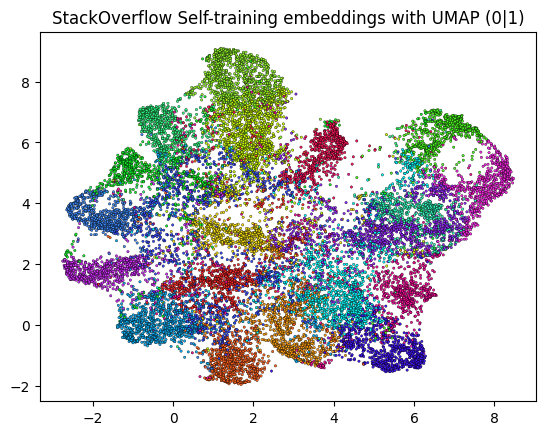

In [21]:
plot.commonSpace_plot(zt.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred, 
                      data_name="StackOverflow", dimred = 'UMAP')

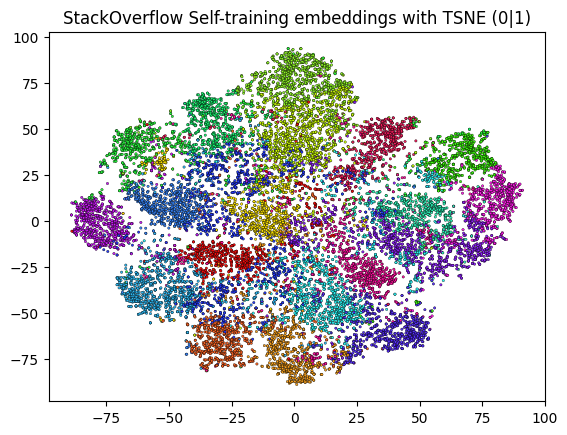

In [22]:
plot.commonSpace_plot(zt.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred, 
                      data_name="StackOverflow", dimred = 'TSNE')

##### Spherical Kmeans

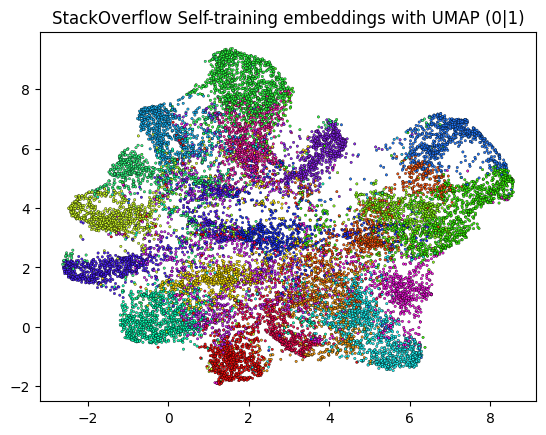

In [23]:
plot.commonSpace_plot(zt.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred, 
                      data_name="StackOverflow", dimred = 'UMAP')

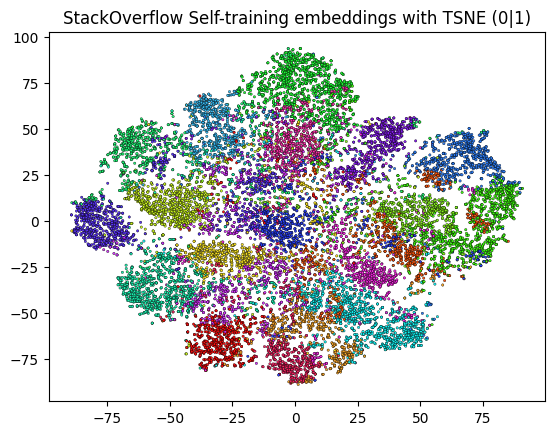

In [24]:
plot.commonSpace_plot(zt.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred, 
                      data_name="StackOverflow", dimred = 'TSNE')

### Config : STC-wdeHuggingFace-scaMinMax-tfeNone-norml2-initSphericalKmeans.pth

In [25]:
dataset = 'stackoverflow'
data_in_dir=join(cur, "..", "datasets")
dataset_dir=join(data_in_dir, dataset)
batch_size=64
maxiter=1000
pretrain_epochs=15
update_interval=30
tol=0.0001
stc_weights=join(data_in_dir, dataset, "artefacts", 
                 "STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeNone-norml2-initSphericalKmeans.pth")
save_dir=join(data_in_dir, dataset, "artefacts")


In [26]:
# STC-wdeWord2Vec-scaMinMax-tfeNone-norml2-initKmeans.pth

x, y = load_data(dataset=dataset_dir, word_emb='Word2Vec', transform=None, scaler='MinMax', norm='l2')
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(stc_weights)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Embedding started...
Word2Vec words embedding loaded...
Average embedding completed...
### Embedding completed...
Spherical normalization completed...


(torch.Size([18000, 48]),
 torch.Size([2000, 48]),
 torch.Size([18000]),
 torch.Size([2000]))

In [27]:
z2t = stc.autoencoder.encoder(X_train)

In [28]:
kmeans2 = KMeans(n_clusters=n_clusters, n_init=50)
kmeans2.fit(z2t.detach().numpy())
y_km_pred2 = kmeans2.labels_

In [29]:
skmeans2 = SphericalKmeans(n_clusters=n_clusters, n_init=50)
skmeans2.fit(z2t.detach().numpy())
y_skm_pred2 = skmeans2.labels_

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

In [30]:
eval.allMetrics(y_train.detach().numpy(), y_km_pred2)

[0.4368, 0.4171, 0.2774]

In [31]:
eval.allMetrics(y_train.detach().numpy(), y_skm_pred2)

[0.4149, 0.4048, 0.2673]

In [32]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_nl2_ikm2 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    kmeans.fit(z2t.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_nl2_ikm2 = np.array(tmp)
avg_w2v_mmx_nl2_ikm2.mean(axis=0), avg_w2v_mmx_nl2_ikm2.std(axis=0)

(array([0.43624, 0.417  , 0.27718]),
 array([0.00047159, 0.00027568, 0.00029933]))

In [33]:
# comprehension list with 5 runs of Sherical kmeans, get average and std of metrics
avg_w2v_mmx_nl2_iskm2 = []
tmp = []
for i in range(5):
    skmeans = SphericalKmeans(n_clusters=n_clusters, n_init=50)
    skmeans.fit(z2t.detach().numpy())
    y_skm_pred = skmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_skm_pred))

avg_w2v_mmx_nl2_iskm2 = np.array(tmp)
avg_w2v_mmx_nl2_iskm2.mean(axis=0), avg_w2v_mmx_nl2_iskm2.std(axis=0)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

(array([0.43744, 0.41552, 0.27534]),
 array([0.00895513, 0.00811108, 0.01094817]))

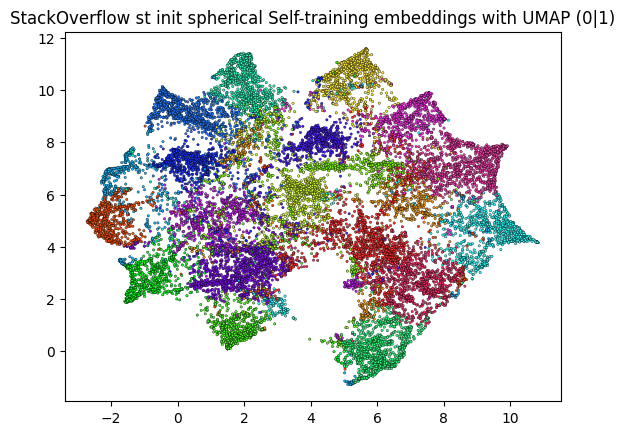

In [34]:
plot.commonSpace_plot(z2t.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred2, 
                      data_name="StackOverflow st init spherical", dimred = 'UMAP')

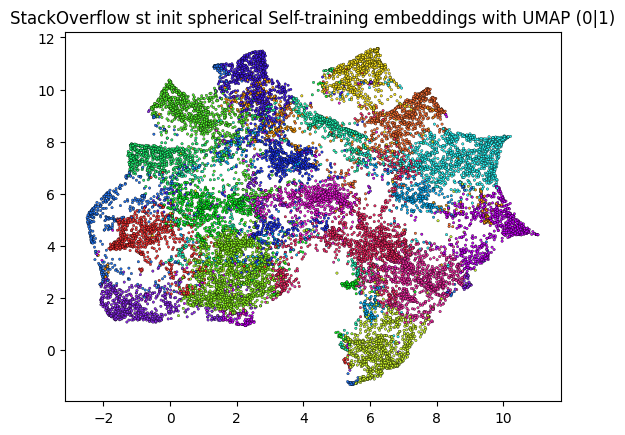

In [35]:
plot.commonSpace_plot(z2t.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred2, 
                      data_name="StackOverflow st init spherical", dimred = 'UMAP')

### Config: datasets/stackoverflow/artefacts/STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeSIF-norml2-initKmeans.pth

In [36]:
dataset = 'stackoverflow'
data_in_dir=join(cur, "..", "datasets")
dataset_dir=join(data_in_dir, dataset)
batch_size=64
maxiter=1000
pretrain_epochs=15
update_interval=30
tol=0.0001
stc_weights=join(data_in_dir, dataset, "artefacts", 
                 "STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeSIF-norml2-initKmeans.pth")
save_dir=join(data_in_dir, dataset, "artefacts")


In [37]:
# STC-wdeWord2Vec-scaMinMax-tfeNone-norml2-initKmeans.pth

x, y = load_data(dataset=dataset_dir, word_emb='Word2Vec', transform='SIF', scaler='MinMax', norm='l2')
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(stc_weights)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Embedding started...
Word2Vec words embedding loaded...
#### SIF embedding started...
SIF-Embedding 19999 documents with 48-dimensional word vectors...
### SIF embedding completed...
### Embedding completed...
Spherical normalization completed...


(torch.Size([18000, 48]),
 torch.Size([2000, 48]),
 torch.Size([18000]),
 torch.Size([2000]))

In [41]:
z3t = stc.autoencoder.encoder(X_train)

In [42]:
kmeans3 = KMeans(n_clusters=n_clusters, n_init=50)
kmeans3.fit(z3t.detach().numpy())
y_km_pred3 = kmeans3.labels_

In [43]:
skmeans3 = SphericalKmeans(n_clusters=n_clusters, n_init=50)
skmeans3.fit(z3t.detach().numpy())
y_skm_pred3 = skmeans3.labels_

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

In [44]:
eval.allMetrics(y_train.detach().numpy(), y_km_pred3)

[0.5606, 0.5122, 0.3764]

In [45]:
eval.allMetrics(y_train.detach().numpy(), y_skm_pred3)

[0.5833, 0.5174, 0.4043]

In [46]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_nl2_ikm3 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    kmeans.fit(z3t.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred3))

avg_w2v_mmx_nl2_ikm3 = np.array(tmp)
avg_w2v_mmx_nl2_ikm3.mean(axis=0), avg_w2v_mmx_nl2_ikm3.std(axis=0)

(array([0.5606, 0.5122, 0.3764]), array([0., 0., 0.]))

In [47]:
# comprehension list with 5 runs of Sherical kmeans, get average and std of metrics
avg_w2v_mmx_nl2_iskm3 = []
tmp = []
for i in range(5):
    skmeans = SphericalKmeans(n_clusters=n_clusters, n_init=50)
    skmeans.fit(z3t.detach().numpy())
    y_skm_pred = skmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_skm_pred3))

avg_w2v_mmx_nl2_iskm3 = np.array(tmp)
avg_w2v_mmx_nl2_iskm3.mean(axis=0), avg_w2v_mmx_nl2_iskm3.std(axis=0)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

(array([0.5833, 0.5174, 0.4043]), array([0., 0., 0.]))

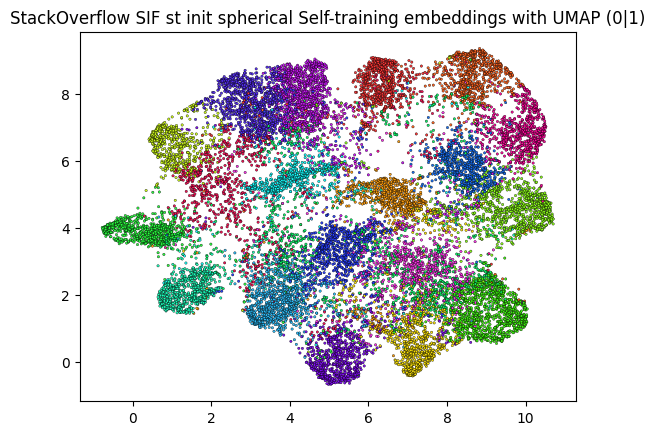

In [48]:
plot.commonSpace_plot(z3t.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred3,
                      data_name="StackOverflow SIF st init spherical", dimred = 'UMAP')

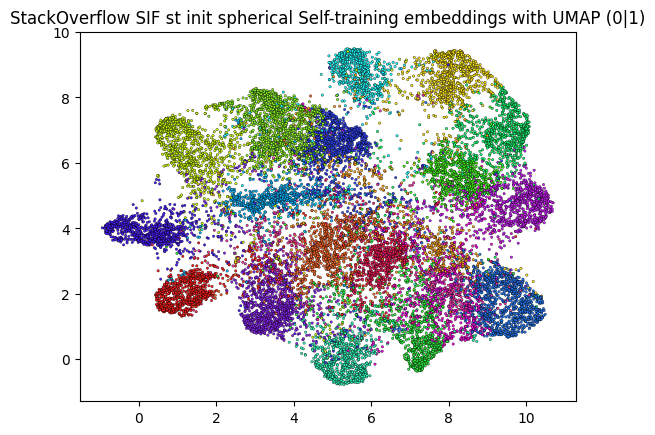

In [49]:
plot.commonSpace_plot(z3t.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred3, 
                      data_name="StackOverflow SIF st init spherical", dimred = 'UMAP')

### Config 4: STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeSIF-norml2-initSphericalKmeans.pth

In [50]:
dataset = 'stackoverflow'
data_in_dir=join(cur, "..", "datasets")
dataset_dir=join(data_in_dir, dataset)
batch_size=64
maxiter=1000
pretrain_epochs=15
update_interval=30
tol=0.0001
stc_weights=join(data_in_dir, dataset, "artefacts", 
                 "STC-datstackoverflow-wdeWord2Vec-scaMinMax-tfeSIF-norml2-initSphericalKmeans.pth")
save_dir=join(data_in_dir, dataset, "artefacts")


In [51]:
# STC-wdeWord2Vec-scaMinMax-tfeNone-norml2-initKmeans.pth

x, y = load_data(dataset=dataset_dir, word_emb='Word2Vec', transform='SIF', scaler='MinMax', norm='l2')
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(stc_weights)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Embedding started...
Word2Vec words embedding loaded...
#### SIF embedding started...
SIF-Embedding 19999 documents with 48-dimensional word vectors...
### SIF embedding completed...
### Embedding completed...
Spherical normalization completed...


(torch.Size([18000, 48]),
 torch.Size([2000, 48]),
 torch.Size([18000]),
 torch.Size([2000]))

In [52]:
z4t = stc.autoencoder.encoder(X_train)

In [53]:
kmeans4 = KMeans(n_clusters=n_clusters, n_init=50)
kmeans4.fit(z4t.detach().numpy())
y_km_pred4 = kmeans4.labels_

In [54]:
skmeans4 = SphericalKmeans(n_clusters=n_clusters, n_init=50)
skmeans4.fit(z4t.detach().numpy())
y_skm_pred4 = skmeans4.labels_

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

In [55]:
eval.allMetrics(y_train.detach().numpy(), y_km_pred4)

[0.5123, 0.4736, 0.3495]

In [56]:
eval.allMetrics(y_train.detach().numpy(), y_skm_pred4)

[0.4967, 0.4702, 0.3489]

In [57]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_nl2_ikm4 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    kmeans.fit(z4t.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred4))

avg_w2v_mmx_nl2_ikm4 = np.array(tmp)
avg_w2v_mmx_nl2_ikm4.mean(axis=0), avg_w2v_mmx_nl2_ikm4.std(axis=0)

(array([0.5123, 0.4736, 0.3495]),
 array([0.00000000e+00, 5.55111512e-17, 0.00000000e+00]))

In [58]:
# comprehension list with 5 runs of Sherical kmeans, get average and std of metrics
avg_w2v_mmx_nl2_iskm4 = []
tmp = []
for i in range(5):
    skmeans = SphericalKmeans(n_clusters=n_clusters, n_init=50)
    skmeans.fit(z4t.detach().numpy())
    y_skm_pred = skmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_skm_pred4))

avg_w2v_mmx_nl2_iskm4 = np.array(tmp)
avg_w2v_mmx_nl2_iskm4.mean(axis=0), avg_w2v_mmx_nl2_iskm4.std(axis=0)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

(array([0.4967, 0.4702, 0.3489]), array([0., 0., 0.]))

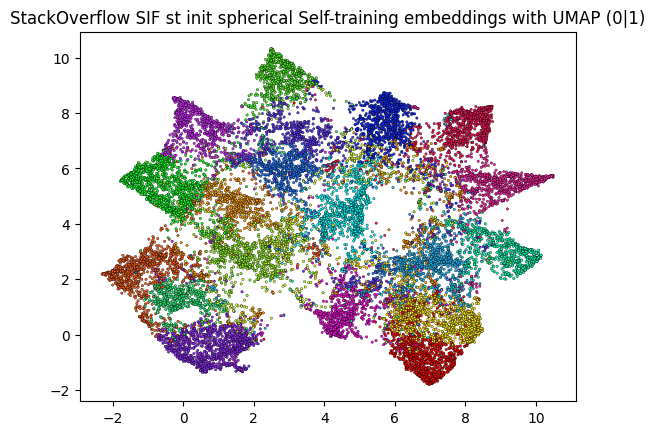

In [59]:
plot.commonSpace_plot(z4t.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred4, 
                      data_name="StackOverflow SIF st init spherical", dimred = 'UMAP')

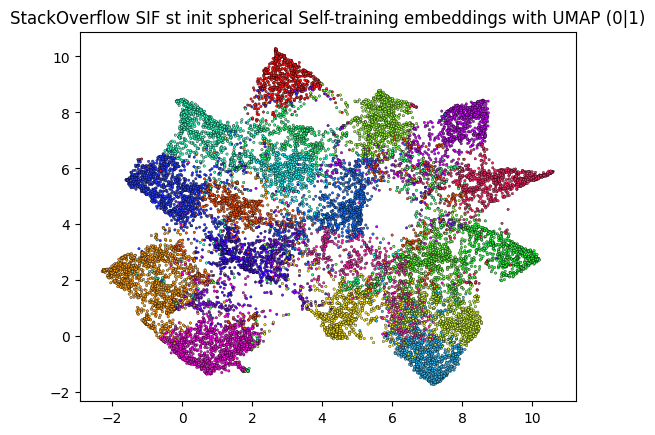

In [60]:
plot.commonSpace_plot(z4t.detach().numpy(), comp=[0, 1], tagLabels=y_skm_pred4, 
                      data_name="StackOverflow SIF st init spherical", dimred = 'UMAP')